# Analysis of gene expression data

# I Data Retrieval
Data Retrieval was done using the RScript!

- Download Data (Uterine Corpus Endometrial Carcinoma)

In [1]:
from pyunpack import Archive
import glob,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy import stats
import statsmodels.stats.multitest as mt

from tqdm import tqdm
import networkx as nx
import seaborn as sns

In [2]:
patients_C=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_patients_C.txt",header=None)
patients_C.columns=['patients']
patients_N=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_patients_N.txt",header=None)
patients_N.columns=['patients']

genes_C=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_expr_data_C.txt",sep=' ')
genes_N=pd.read_csv("TCGA-UCEC/TCGA-UCEC_rna_expr_data_N.txt",sep=' ')



In [3]:
clinical_data=pd.read_csv("TCGA-UCEC/TCGA-UCEC_clinical_data.txt")

In [4]:
print(patients_C.shape[0],'  --------> patients with cancer')
print(patients_N.shape[0],'  --------> patients without cancer')

551   --------> patients with cancer
35   --------> patients without cancer


In [5]:
print('Number of genes available -------->',len(set(genes_C.index).intersection(set(genes_N.index))))

Number of genes available --------> 56512


In [6]:
##Select only patients for whom cancer and normal tissue files are available.
patients_C_N=(set(patients_C.patients).intersection(set(patients_N.patients))) # consider 23 patients
print('Number of patients for whom cancer and normal tissue files are available -------->', len(patients_C_N))

patients_C_N

Number of patients for whom cancer and normal tissue files are available --------> 23


{'TCGA-AJ-A2QL',
 'TCGA-AJ-A3NC',
 'TCGA-AJ-A3NE',
 'TCGA-AJ-A3NH',
 'TCGA-AX-A05Y',
 'TCGA-AX-A0IZ',
 'TCGA-AX-A0J0',
 'TCGA-AX-A1CF',
 'TCGA-AX-A1CI',
 'TCGA-AX-A1CK',
 'TCGA-AX-A2H8',
 'TCGA-AX-A2HA',
 'TCGA-AX-A2HC',
 'TCGA-AX-A2HD',
 'TCGA-BG-A2AD',
 'TCGA-BG-A3EW',
 'TCGA-BG-A3PP',
 'TCGA-BK-A0CB',
 'TCGA-BK-A13C',
 'TCGA-BK-A4ZD',
 'TCGA-DI-A2QU',
 'TCGA-DI-A2QY',
 'TCGA-E6-A1M0'}

In [7]:
genes_N_T = genes_N.T 
genes_N_T['patient'] = list(genes_N_T.index)

patients_lst = genes_N_T.patient.apply(lambda x: x[:12])
genes_N_T['patient'] = patients_lst

genes_N_T.set_index('patient',drop=True,inplace=True)

genes_N = genes_N_T[genes_N_T.index.isin(patients_C_N)].T

In [8]:
genes_C_T = genes_C.T 
genes_C_T['patient'] = list(genes_C_T.index)

patients_lst = genes_C_T.patient.apply(lambda x: x[:12])
genes_C_T['patient'] = patients_lst

genes_C_T.set_index('patient',drop=True,inplace=True)

genes_C = genes_C_T[genes_C_T.index.isin(patients_C_N)].T

In [9]:
set(genes_C.index==genes_N.index) #check of order of genes is the same in both dataframes

{True}

In [10]:
print(genes_C.shape)
print(genes_N.shape)

(56512, 23)
(56512, 23)


In [11]:
genes_CN=genes_C.join(genes_N,lsuffix='_caller', rsuffix='_other',how='inner') #BOTH C and N

# II  Identify Differentially expressed genes

 

2. Identify Differentially Expressed Genes (DEGs) specifying the thresholds setting. Select the thresholds to obtain a subset of hundreds of genes: p-value should be less than or equal to 0.05 (it is suggested to apply a correction for multiple comparisons) and Fold Change greater than or equal to 1.2.


## Which genes are differentially expressed?


**Fold Change**
A first criterion can be to identify the genes whose expression in the two
groups of samples considered varies by a certain proportion (doubles,
halves, ...)

𝑓𝑜𝑙𝑑𝑐ℎ𝑎𝑛𝑔𝑒=$𝑙𝑜𝑔_2\frac{𝐸𝑥𝑝𝑟𝑐𝑜𝑛𝑑1}{𝐸𝑥𝑝𝑟𝑐𝑜𝑛𝑑2}$=2


Condition 1 - Cancer

Condition 2 - Normal

In [12]:
all_test_pairs=pd.read_csv('t_test_all_pairs.csv') #'t_test_all_pairs_Welch.csv')#
fold_df=np.log2(genes_C.sum(axis=1))-np.log2(genes_N.sum(axis=1))
all_test_pairs['fc']=fold_df.values

C:\Users\dusic\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
## REMOVE  GENES WITH NO CHANGE in expression value; all zeros; AKA sum of rows is 0 in BOTH CONDITIONS
gg=genes_CN[genes_CN.sum(axis=1)!=0].index

In [14]:
all_df=all_test_pairs.copy()

all_df=all_df[all_df.gene.isin(gg)]
all_df=all_df[(all_df.fc!=-np.inf)|(all_df.fc!=np.inf)]

all_df['adj_pvalue']=mt.multipletests(all_df.pvalue, alpha=0.01, method='fdr_bh')[1]#, is_sorted=False, returnsorted=False) 
all_df['log_pval']=all_df.adj_pvalue.apply(lambda x:-np.log10(x))


From  56512 to -------> 380 gene samples


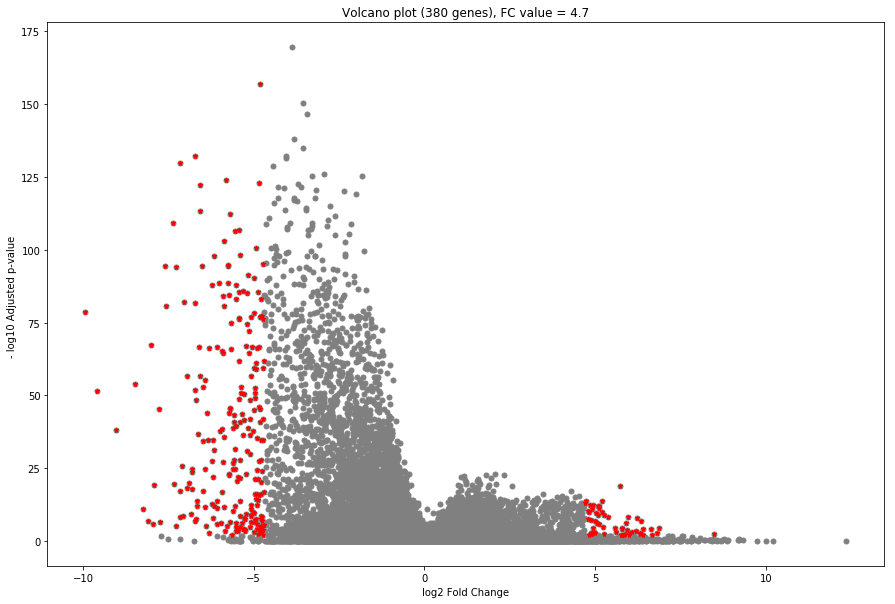

In [15]:
s=5
th=4.7  ##SPECIFY the FC Threshold

plt.figure(figsize=(15,10))
 
plt.plot(all_df.fc.values,all_df['log_pval'],'o',color='gray',markersize=s)
threshold1=np.where((all_df.fc>=th ) | (all_df.fc<=-th))[0]
threshold2=np.where(all_df['adj_pvalue']<0.01)[0]
ind=list(set(threshold1).intersection(set(threshold2)))

x=all_df.fc.iloc[ind].values
y=all_df['log_pval'].iloc[ind].values
plt.plot(x,y,'*',color='red',markersize=s)
title='Volcano plot '
title=title+'('+str(len(x))+' genes)'+', FC value = '+str(th)
plt.title(title)
plt.xlabel('log2 Fold Change')
plt.ylabel('- log10 Adjusted p-value ')
plt.savefig(title+'.png')
print('From ',genes_C.shape[0],'to ------->',len(x),'gene samples')

In [16]:

genes_N=genes_N[genes_N.index.isin(gg)]
genes_C=genes_C[genes_C.index.isin(gg)]
#fold_df=np.abs(np.log2(genes_C.sum(axis=1)/genes_N.sum(axis=1)))
fold_df=np.log2(genes_C.sum(axis=1)/genes_N.sum(axis=1))

fold_df=fold_df[(fold_df!=np.inf) & ((fold_df!=-np.inf))]

##fold_df=np.abs(np.log2(genes_C.sum(axis=1))-np.log2(genes_N.sum(axis=1)))

fold_sort_df=pd.DataFrame(fold_df[fold_df>=4.7]) ##Decide on this threshold and p-value threshold

th=4.7

fold_sort_df=pd.DataFrame(fold_df[(fold_df>=th) | (fold_df<=-th)])

fold_sort_df.columns=['fold_value']


#drop nan and inf(when log is not defined--> log0)
fold_sort_df.dropna(inplace=True)
fold_sort_df=fold_sort_df[(fold_sort_df.fold_value!=np.inf) & ((fold_sort_df.fold_value!=-np.inf))]
#fold_sort_df=fold_sort_df.sort_values(['fold_value'],ascending=False)

C:\Users\dusic\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


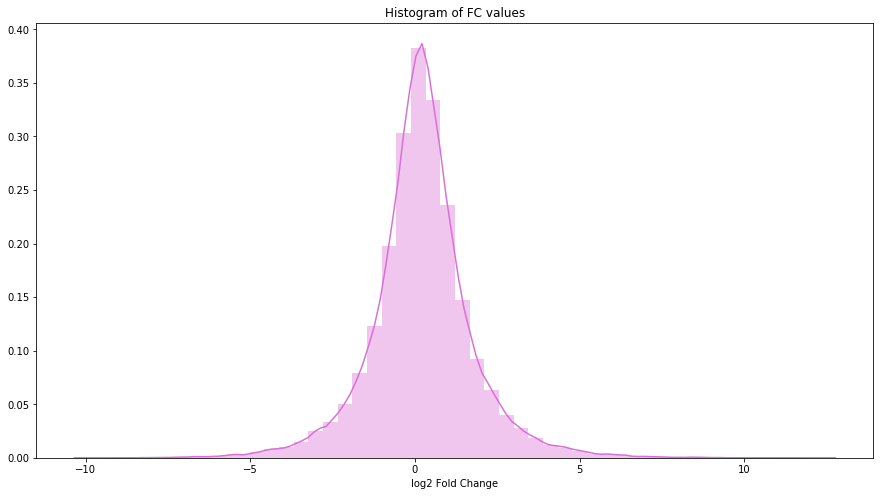

In [17]:
#from scipy.stats import norm
plt.figure(figsize=(15,8))
t='Histogram of FC values'
plt.title(t)
plt.xlabel('log2 Fold Change')


sns.distplot(fold_df,hist=True,color='orchid')#fit=norm,
plt.savefig(t+'.png')

## Statistical tests
## Student’s t test for two conditions/groups (control vs treated)

In [18]:
fold_sort_df.index #USE JUST THESE GENES which have fold value >= chosen threshold

Index(['ENSG00000007908', 'ENSG00000008196', 'ENSG00000009709',
       'ENSG00000011465', 'ENSG00000012504', 'ENSG00000022267',
       'ENSG00000043355', 'ENSG00000047936', 'ENSG00000050628',
       'ENSG00000054938',
       ...
       'ENSG00000279127', 'ENSG00000279511', 'ENSG00000279694',
       'ENSG00000280081', 'ENSG00000280319', 'ENSG00000280323',
       'ENSG00000280362', 'ENSG00000280435', 'ENSG00000281809',
       'ENSG00000281852'],
      dtype='object', length=724)

In [19]:
genes_C_reduced=genes_C[genes_C.index.isin(fold_sort_df.index)]
genes_N_reduced=genes_N[genes_N.index.isin(fold_sort_df.index)]

Because of the fold change we reduced # of DEG 

In [20]:
print('From ',genes_C.shape[0],'to ------->',genes_C_reduced.shape[0],' in the Primary solid Tumor data')
print('From ',genes_N.shape[0],'to ------->',genes_N_reduced.shape[0],' in the Solid Tissue Normal data')

From  51242 to -------> 724  in the Primary solid Tumor data
From  51242 to -------> 724  in the Solid Tissue Normal data


### Performing t-tests for each gene for both conditions 

In [21]:
stat_lst=[]
pvalue_lst=[]
ttest_df=pd.DataFrame(columns=['gene','statistic','pvalue'])
for i in tqdm(range(genes_C_reduced.shape[0])):# FOR ALL
    res=stats.ttest_ind(genes_C_reduced.iloc[i,:],genes_N_reduced.iloc[i,:])##,equal_var=False)
    stat_lst.append(res[0])
    pvalue_lst.append(res[1])
    ttest_df=ttest_df.append({'gene':genes_C_reduced.index[i],'statistic':res[0],'pvalue':res[1]},ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████| 724/724 [00:05<00:00, 140.12it/s]


In [22]:
#pd.read_csv('t_test_all_pairs.csv')
#pd.read_csv('t_test_all_pairs_Welch.csv')

In [23]:
ttest_df[ttest_df.pvalue<0.01]

,gene,statistic,pvalue
3,ENSG00000011465,-5.642647,1.127851e-06
5,ENSG00000022267,-6.662924,3.572498e-08
8,ENSG00000050628,-3.968372,2.635148e-04
9,ENSG00000054938,-2.894674,5.886802e-03
11,ENSG00000065328,5.380526,2.719355e-06
...,...,...,...
713,ENSG00000278195,-3.158250,2.866784e-03
715,ENSG00000279511,3.503523,1.067529e-03
718,ENSG00000280319,-3.136490,3.045870e-03
719,ENSG00000280323,-3.139060,3.024183e-03


In [24]:
# HOW many? DEG pairs
ttest_df[ttest_df.pvalue<0.01].shape[0]

284

Correction method for p-values used:
        
        • FDR (False Discovery Rate): check if the k th ordered p value is larger
          than (k × a)/N  --->Benjamini/Hochberg (non-negative)
          


In [25]:
corr=mt.multipletests(ttest_df.pvalue, alpha=0.01, method='fdr_bh')#, is_sorted=False, returnsorted=False) 
#fdr_bh : Benjamini/Hochberg (non-negative)

#### after applied correction

# Final DEGs after applied correction

In [26]:
after_correction=ttest_df[corr[0]]
final_degs_number=after_correction.shape[0]

In [27]:
set(after_correction.gene).intersection(genes_CN[genes_CN.sum(axis=1)<0.1].index)

set()

In [28]:
after_correction[after_correction.pvalue<0.01].shape #check

(226, 3)

In [29]:
#example of 3 DEG in normal and cancer tissue sample
def plotGenes(example_genes,title):
    plt.figure(figsize=(20,10)) 
    for idx,ex in enumerate(example_genes):
        tissue_C = genes_CN[genes_CN.index==example_genes[idx]].values.tolist()[0]
#        tissue_N = genes_N[genes_N.index==example_genes[idx]].values.tolist()[0]

        plt.plot(range(1,len(tissue_C)+1),tissue_C)


    plt.legend(example_genes)
    plt.axvline(5, linewidth=780,  color = 'r',alpha=0.05)
    plt.axvline(40, linewidth=800,  color = 'b',alpha=0.05)
    plt.savefig(title+'.png')
    plt.title(title)
    plt.show()

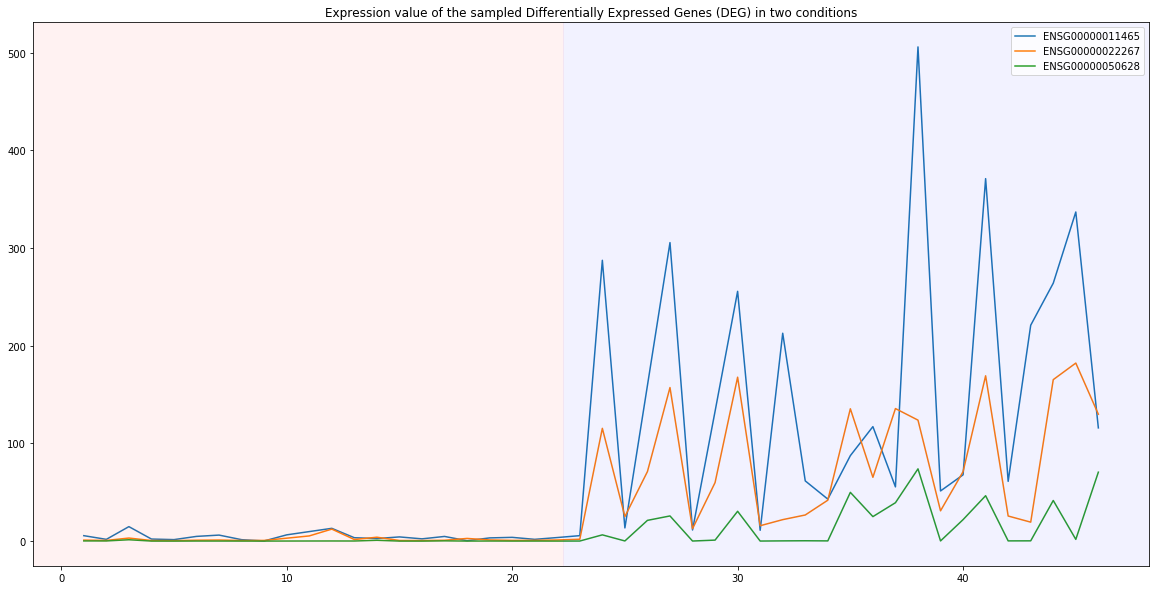

In [30]:
DEG_examples=list(after_correction.gene[after_correction.gene.index[:3]])
plotGenes(DEG_examples,title='Expression value of the sampled Differentially Expressed Genes (DEG) in two conditions')

In [31]:
th=1
fdf=pd.DataFrame(fold_df[(fold_df<=th) & (fold_df>=-th)])
fdf.columns=['fold_value']


#drop nan and inf(when log is not defined--> log0)
fdf.dropna(inplace=True)
fdf=fdf[(fdf.fold_value!=np.inf)]
fdf=fdf.sort_values(['fold_value'],ascending=True)

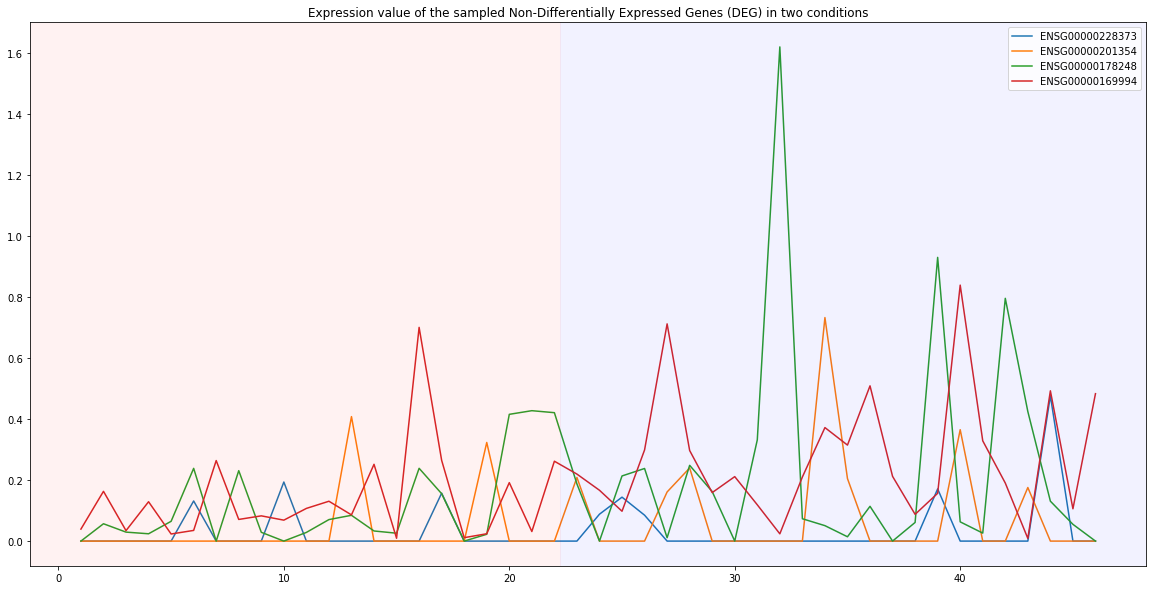

In [32]:
Non_DEG_examples=list(fdf.index[[0,3,4,5]])
plotGenes(Non_DEG_examples,title='Expression value of the sampled Non-Differentially Expressed Genes (DEG) in two conditions')

# III Gene co-expression 
 

## Which and how many genes are co expressed?

3. Using only DEGs, compute the gene co-expression networks related to the 2 conditions (cancer, normal) considering:
        o Pearson’s correlation;
        o Binary adjacency matrix where aij=0 if |R|<0.7 (where R is the Pearson correlation coefficient).

In [33]:
chosen_genes_C=genes_C[genes_C.index.isin(after_correction.gene.values)]
chosen_genes_N=genes_N[genes_N.index.isin(after_correction.gene.values)]

In [34]:
set(chosen_genes_N.columns).intersection(chosen_genes_C.columns)

{'TCGA-AJ-A2QL',
 'TCGA-AJ-A3NC',
 'TCGA-AJ-A3NE',
 'TCGA-AJ-A3NH',
 'TCGA-AX-A05Y',
 'TCGA-AX-A0IZ',
 'TCGA-AX-A0J0',
 'TCGA-AX-A1CF',
 'TCGA-AX-A1CI',
 'TCGA-AX-A1CK',
 'TCGA-AX-A2H8',
 'TCGA-AX-A2HA',
 'TCGA-AX-A2HC',
 'TCGA-AX-A2HD',
 'TCGA-BG-A2AD',
 'TCGA-BG-A3EW',
 'TCGA-BG-A3PP',
 'TCGA-BK-A0CB',
 'TCGA-BK-A13C',
 'TCGA-BK-A4ZD',
 'TCGA-DI-A2QU',
 'TCGA-DI-A2QY',
 'TCGA-E6-A1M0'}

In [35]:
all_chosen=chosen_genes_C.T.append(chosen_genes_N.T)#chosen_genes_C.append(chosen_genes_N)
all_chosen.shape

(46, 226)

In [36]:
all_chosen=all_chosen.apply(lambda x: x.astype('float64'))
all_chosen.shape

(46, 226)

In [37]:
corr_matrix=all_chosen.corr(method = 'pearson').apply(lambda x: abs(x))  ##  o Pearson’s correlation matrix

In [38]:
corr_matrix.iloc[:3,:3] #diagonal needs to have zeros and 1 if Pearson correlation coefficient is > 0.7

,ENSG00000011465,ENSG00000022267,ENSG00000050628
ENSG00000011465,1.000000,0.808708,0.629326
ENSG00000022267,0.808708,1.000000,0.767603
ENSG00000050628,0.629326,0.767603,1.000000


In [39]:
def adj_method(x):
    if x>0.7:       
        return 1
    else:
        return 0

In [40]:
## o Binary adjacency matrix where aij=0 if |R|<0.7 (where R is the Pearson correlation coefficient).

In [41]:
adj_matrix=corr_matrix.copy()
np.fill_diagonal(adj_matrix.values, 0)

for col in adj_matrix.columns:
    adj_matrix[col]=adj_matrix[col].apply(adj_method)

In [42]:
def corrAndAdj(data):
    corr_matrix=data.corr(method = 'pearson').apply(lambda x: abs(x))  ##  o Pearson’s correlation matrix
    adj_matrix=corr_matrix.copy()
    np.fill_diagonal(adj_matrix.values, 0)

    for col in adj_matrix.columns:
        adj_matrix[col]=adj_matrix[col].apply(adj_method)
    return corr_matrix,adj_matrix

In [43]:
corr_matrix_N,adj_matrix_N = corrAndAdj(chosen_genes_N.T)
corr_matrix_C,adj_matrix_C = corrAndAdj(chosen_genes_C.T)
corr_matrix_CN,adj_matrix_CN = corrAndAdj(all_chosen)

In [44]:
corr_matrix_C.iloc[:3,:3]  #small example of correlation matrix for Cancer condition

,ENSG00000011465,ENSG00000022267,ENSG00000050628
ENSG00000011465,1.000000,0.665300,0.527018
ENSG00000022267,0.665300,1.000000,0.208256
ENSG00000050628,0.527018,0.208256,1.000000


In [45]:
corr_matrix_N.iloc[:3,:3]  #small example of correlation matrix for Normal condition

,ENSG00000011465,ENSG00000022267,ENSG00000050628
ENSG00000011465,1.000000,0.650463,0.453900
ENSG00000022267,0.650463,1.000000,0.667442
ENSG00000050628,0.453900,0.667442,1.000000


In [46]:
corr_matrix_CN.iloc[:3,:3]  #small example of correlation matrix for BOTH conditions

,ENSG00000011465,ENSG00000022267,ENSG00000050628
ENSG00000011465,1.000000,0.808708,0.629326
ENSG00000022267,0.808708,1.000000,0.767603
ENSG00000050628,0.629326,0.767603,1.000000


# IV Find HUBS
 

4. Compute the degree index and find the hubs (5% of the nodes with highest degree values)
5. Compare hubs sets related to the two condition (cancer, normal) and identify the hubs characterizing only cancer tissue.

In [47]:
am=adj_matrix#[adj_matrix==1]
>>> G = nx.from_pandas_adjacency(am)
>>> G.name = 'Gene co-expression network from adjacency matrix'
>>> print(nx.info(G))

Name: Gene co-expression network from adjacency matrix
Type: Graph
Number of nodes: 226
Number of edges: 2754
Average degree:  24.3717


plt.figure(3,figsize=(9,9)) 
nx.draw(G,node_size=20)

In [48]:
def show_graph_with_labels(adjacency_matrix,title,resp,col):
    plt.figure(figsize=(20,25)) 
   
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    mylabels={}
    for idx,val in enumerate(adjacency_matrix.index):
        if idx in set(rows):
               mylabels[idx]=val
        else: 
            continue
    plt.title(title)
    
    nx.draw(gr, node_size=150, labels=mylabels, with_labels=resp,node_color=col)
    plt.savefig(title+'.png')
    
    
    plt.show()
    
    

C:\Users\dusic\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


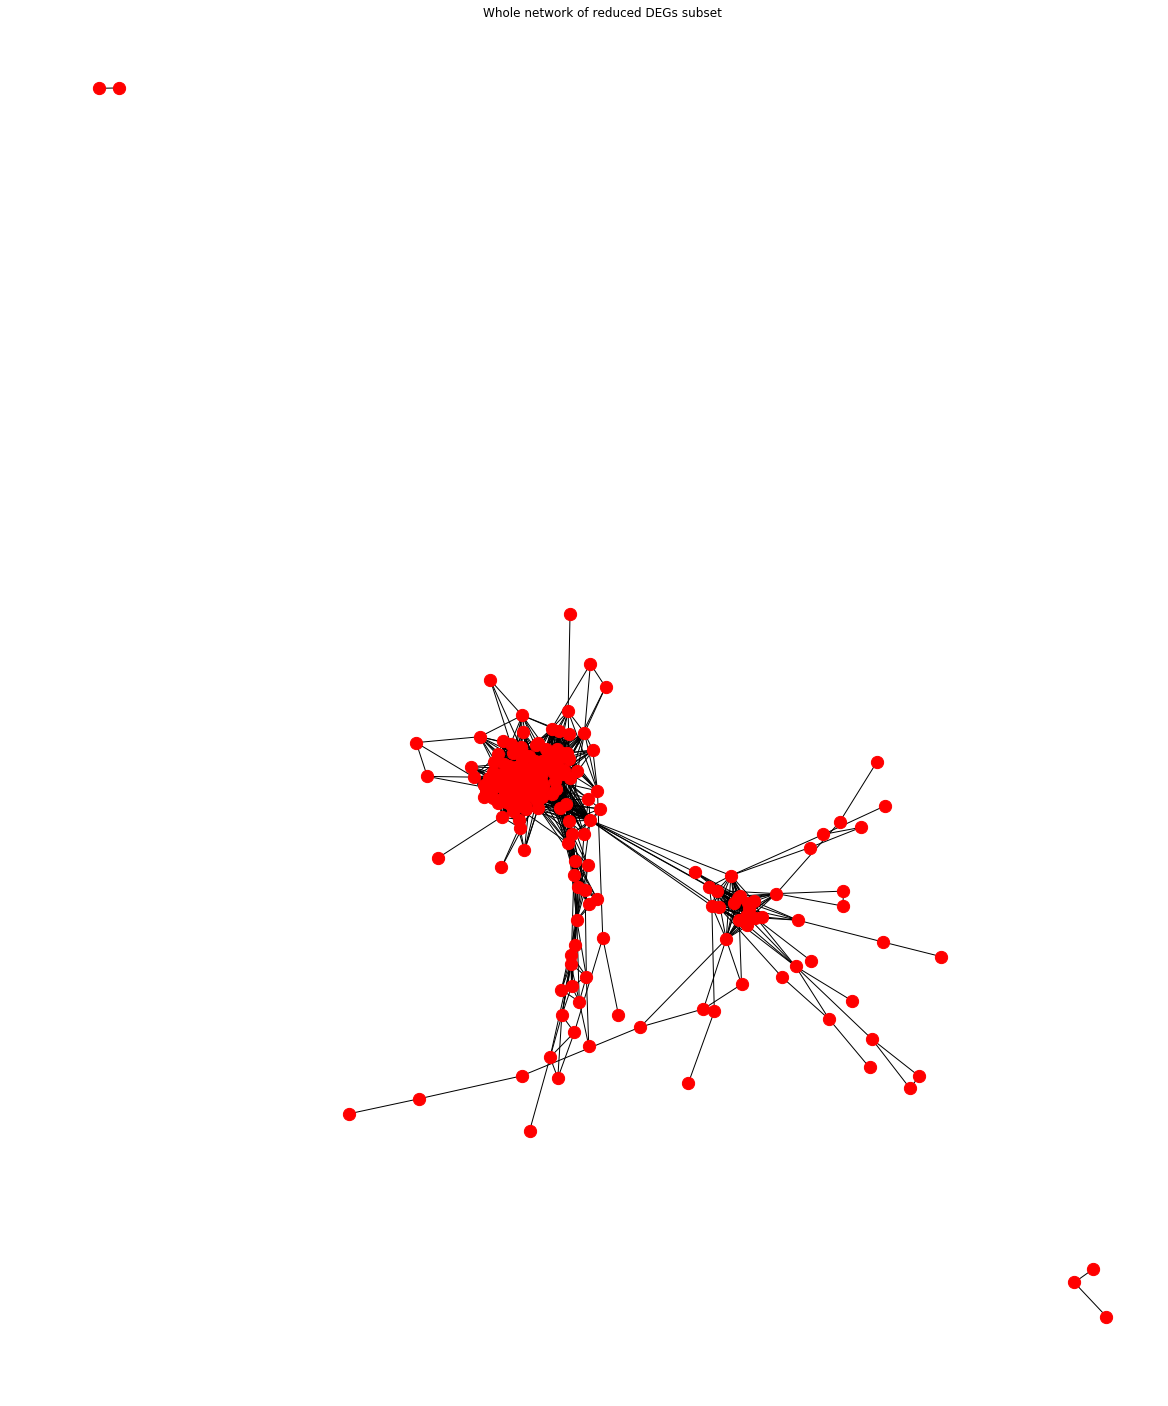

In [49]:
title='Whole network of reduced DEGs subset'
show_graph_with_labels(am,title,False,col='red')

In [50]:
final_degs_number

226

In [51]:
0.05*final_degs_number

11.3

The method below computes degrees of nodes and returns list of hubs.
->we dont need to compute shortest pathes or smth, we just need to take into consideration nodes which has the highest values of degree

In [52]:
def top_k(adj_matr): # method for  4th question
    idx_i, idx_j = np.where(adj_matr==1)
    idx_i, idx_j = list(idx_i), list(idx_j)
    Edges = [(adj_matr.index[idx_i[i]],adj_matr.index[idx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=idx_j[i])]
    out_degrees_of_nodes={'1':0}
    in_degrees_of_nodes={'1':0}
    for i in range(len(Edges)):
        if Edges[i][0] in out_degrees_of_nodes.keys():
            out_degrees_of_nodes[Edges[i][0]]=out_degrees_of_nodes[Edges[i][0]]+1
        else:
            out_degrees_of_nodes[Edges[i][0]]=1
        if Edges[i][1] in in_degrees_of_nodes.keys():
            in_degrees_of_nodes[Edges[i][1]]=in_degrees_of_nodes[Edges[i][1]]+1
        else:
            in_degrees_of_nodes[Edges[i][1]]=1
    del in_degrees_of_nodes['1']
    del out_degrees_of_nodes['1']
    print("in_degree")
    print(np.sum(list(in_degrees_of_nodes.values())))
    print("out_degree")
    print(np.sum(list(out_degrees_of_nodes.values())))
    # results shows that we have undirected graph
    check=[]
    for i in in_degrees_of_nodes.keys():
        check.append(in_degrees_of_nodes[i]==out_degrees_of_nodes[i])
    print(set(check))
    top_5_percent = int(len(list(adj_matr.index))*0.05)
    sorted_list = sorted(in_degrees_of_nodes.items(), key=lambda x: x[1], reverse=True)
    return sorted_list[:top_5_percent]

In [53]:
hubs_C = top_k(adj_matrix_C)

in_degree
978
out_degree
978
{True}


In [54]:
hubs_C

[('ENSG00000146477', 23),
 ('ENSG00000124212', 22),
 ('ENSG00000130176', 22),
 ('ENSG00000154553', 22),
 ('ENSG00000175084', 21),
 ('ENSG00000121871', 21),
 ('ENSG00000133392', 20),
 ('ENSG00000163431', 20),
 ('ENSG00000235782', 20),
 ('ENSG00000254959', 20),
 ('ENSG00000260403', 20)]

In [55]:
hubs_N = top_k(adj_matrix_N)

in_degree
2320
out_degree
2320
{True}


In [56]:
hubs_N

[('ENSG00000172403', 41),
 ('ENSG00000198523', 41),
 ('ENSG00000022267', 41),
 ('ENSG00000065534', 39),
 ('ENSG00000077157', 39),
 ('ENSG00000138944', 39),
 ('ENSG00000254510', 38),
 ('ENSG00000163431', 35),
 ('ENSG00000130176', 32),
 ('ENSG00000149596', 30),
 ('ENSG00000154553', 30)]

In [57]:
# for the 5th question of our project, just to get difference, it seems
# it is totally different

In [65]:
len(hubs_C)

11

In [64]:
set([i[0] for i in hubs_N]).intersection(set([i[0] for i in hubs_C]))

{'ENSG00000130176', 'ENSG00000154553', 'ENSG00000163431'}

In [58]:
set(hubs_C).difference(set(hubs_N))

{('ENSG00000121871', 21),
 ('ENSG00000124212', 22),
 ('ENSG00000130176', 22),
 ('ENSG00000133392', 20),
 ('ENSG00000146477', 23),
 ('ENSG00000154553', 22),
 ('ENSG00000163431', 20),
 ('ENSG00000175084', 21),
 ('ENSG00000235782', 20),
 ('ENSG00000254959', 20),
 ('ENSG00000260403', 20)}

C:\Users\dusic\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


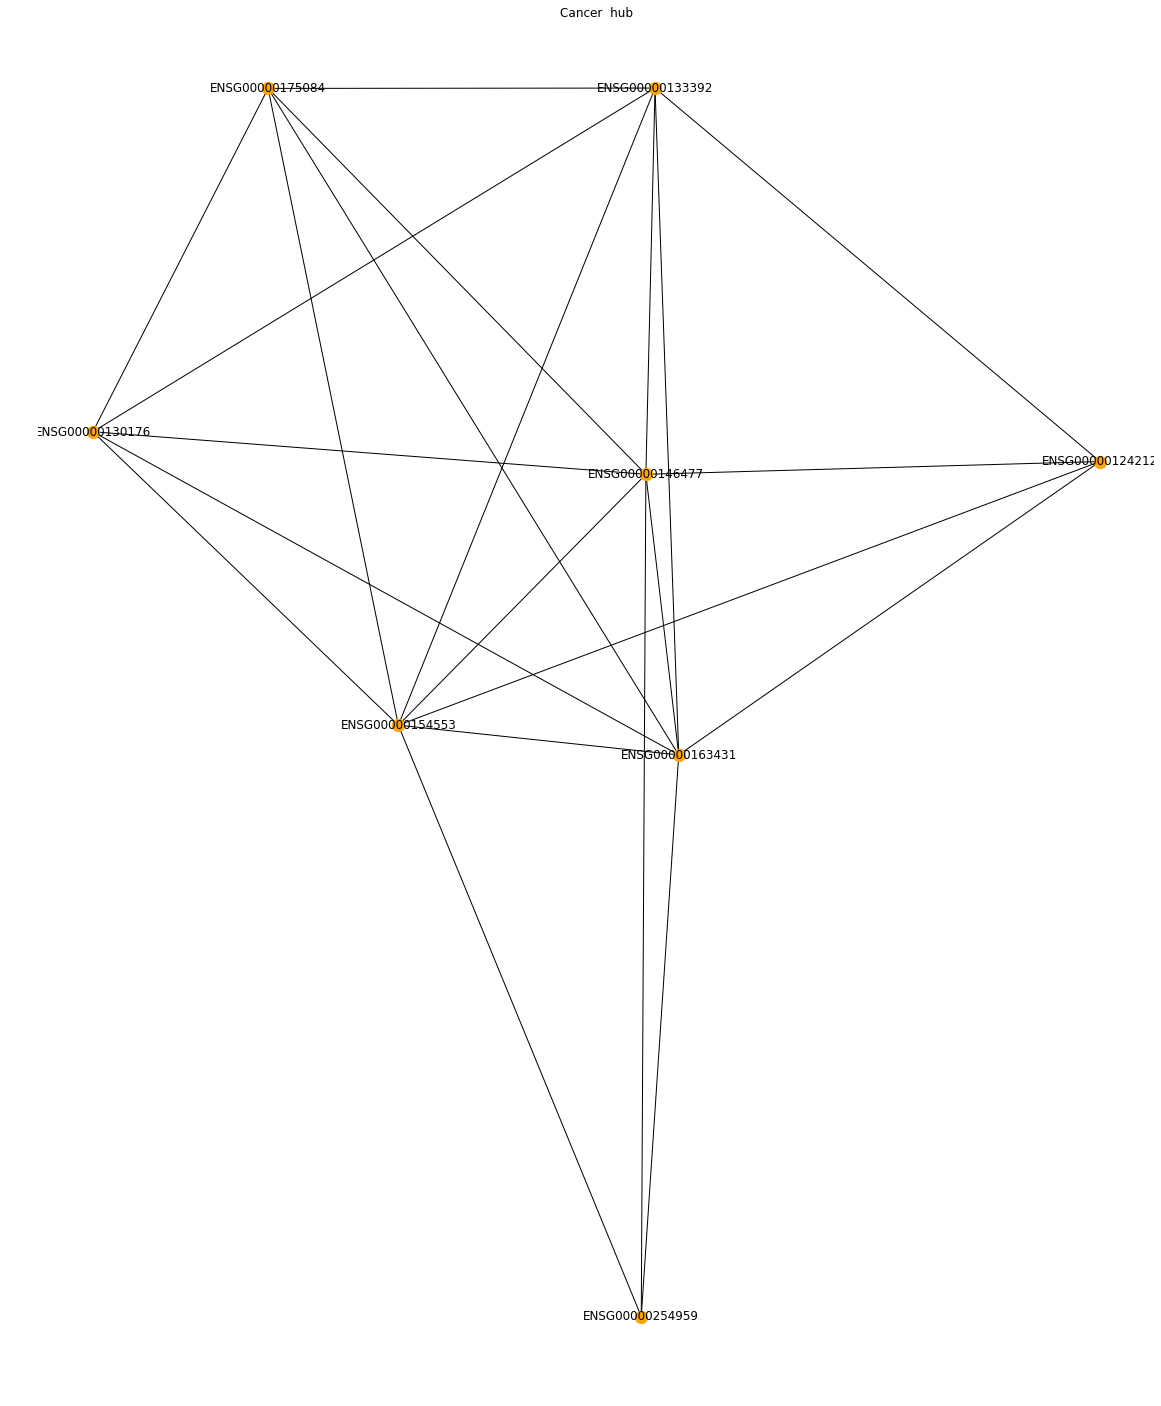

In [59]:
l=[i[0] for i in hubs_C]
adj_matrix_hubC=adj_matrix.loc[l,l]
title='Cancer  hub'
show_graph_with_labels(adj_matrix_hubC,title,True,col='orange')

C:\Users\dusic\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


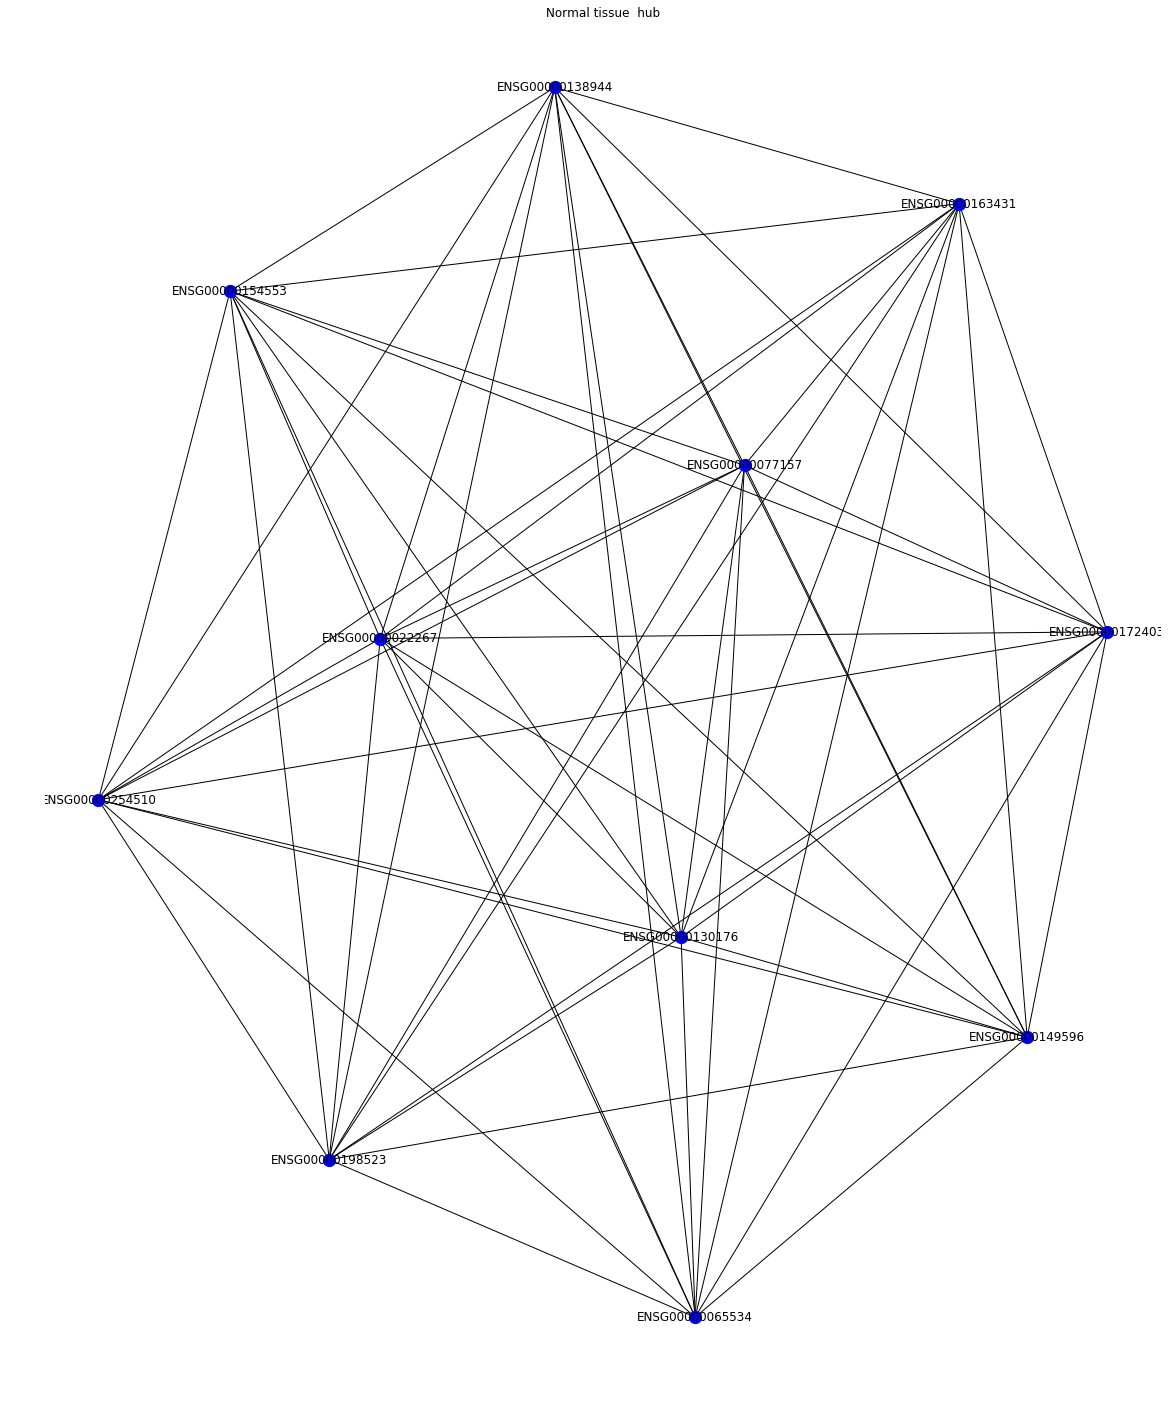

In [60]:
title='Normal tissue  hub'
l=[i[0] for i in hubs_N]
adj_matrix_hubN=adj_matrix.loc[l,l]
show_graph_with_labels(adj_matrix_hubN,title,True,col='blue')